# Experiments on the German Credit datasets
Old version: https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)
Corrected version: https://archive.ics.uci.edu/ml/datasets/South+German+Credit+%28UPDATE%29 / https://www.kaggle.com/c/south-german-credit-prediction/overview/data-overview

Some meanings of the discrete/ordinal feature values in the old version were wrong.
For example, for feature "checking status",

(inferred by the old dataset) a data object's value is                    '1' in the old dataset meaning negative DM.
(by new dataset) However, it should have been value          '4' in the old dataset meaning no checking account

(inferred by the old dataset) a data object's value is                    **'2' in the new dataset** *meaning negative DM*
(by new dataset) However, it should have been value          '1' in the old dataset meaning no checking account

Whether using the encoding scheme in the old or the new dataset, the feature value should be corrected according to the true meaning. The procedures in this experiment are:
1. Encode the dataset using the new dataset's meaning,
2. According to the *meanings of the old dataset*, **find encoded number in the new dataset and modify the feature values**.
3. Train first on the data points by *meanings of the old dataset* to get the base NN
4. gradually train on the data points by meanings of the new dataset to get the shifted NNs.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from utilexp import *
from expnns.utilcredit import *
from expnns.preprocessor import Preprocessor

### Process the old version dataset

In [2]:
df_old, df_old_mm, df_old_enc, preprocessor_old = load_old("../datasets/credit/old/german.data")

In [3]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   checking-status  1000 non-null   int64
 1   duration         1000 non-null   int64
 2   credit-history   1000 non-null   int64
 3   purpose          1000 non-null   int64
 4   amount           1000 non-null   int64
 5   savings          1000 non-null   int64
 6   employment       1000 non-null   int64
 7   rate             1000 non-null   int64
 8   sex-status       1000 non-null   int64
 9   guarantors       1000 non-null   int64
 10  residence        1000 non-null   int64
 11  property         1000 non-null   int64
 12  age              1000 non-null   int64
 13  installment      1000 non-null   int64
 14  housing          1000 non-null   int64
 15  num-credits      1000 non-null   int64
 16  job              1000 non-null   int64
 17  liable           1000 non-null   int64
 18  phone    

In [4]:
df_old_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   checking-status_0  1000 non-null   float64
 1   checking-status_1  1000 non-null   float64
 2   checking-status_2  1000 non-null   float64
 3   checking-status_3  1000 non-null   float64
 4   duration           1000 non-null   float64
 5   credit-history_0   1000 non-null   float64
 6   credit-history_1   1000 non-null   float64
 7   credit-history_2   1000 non-null   float64
 8   credit-history_3   1000 non-null   float64
 9   credit-history_4   1000 non-null   float64
 10  purpose_0          1000 non-null   float64
 11  purpose_1          1000 non-null   float64
 12  purpose_2          1000 non-null   float64
 13  purpose_3          1000 non-null   float64
 14  purpose_4          1000 non-null   float64
 15  purpose_5          1000 non-null   float64
 16  purpose_6          1000 n

In [5]:
display(pd.DataFrame(data=df_old_mm.values[-1].reshape(1, -1), columns=columns))
display(preprocessor_old.encode_one(df_old_mm.values[-1]))

,checking-status,duration,credit-history,purpose,amount,savings,employment,rate,sex-status,guarantors,residence,property,age,installment,housing,num-credits,job,liable,phone,foreign,good-credit
0,2.0,0.602941,1.0,2.0,0.238032,2.0,0.0,2.0,1.0,0.0,3.0,1.0,0.142857,2.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0


,checking-status_0,checking-status_1,checking-status_2,checking-status_3,duration,credit-history_0,credit-history_1,credit-history_2,credit-history_3,credit-history_4,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,amount,savings_0,savings_1,savings_2,savings_3,savings_4,employment_0,employment_1,employment_2,employment_3,employment_4,rate_0,rate_1,rate_2,rate_3,sex-status_0,sex-status_1,sex-status_2,sex-status_3,guarantors_0,guarantors_1,guarantors_2,residence_0,residence_1,residence_2,residence_3,property_0,property_1,property_2,property_3,age,installment_0,installment_1,installment_2,housing_0,housing_1,housing_2,num-credits_0,num-credits_1,num-credits_2,num-credits_3,job_0,job_1,job_2,job_3,liable_0,liable_1,phone_0,phone_1,foreign_0,foreign_1,good-credit
0,1.0,1.0,1.0,0.0,0.602941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.238032,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.142857,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [6]:
Xo, yo = df_old_enc.drop(columns=['good-credit']), pd.DataFrame(df_old_enc['good-credit'])
SPLIT = .2
Xo_train, Xo_test, yo_train, yo_test = train_test_split(Xo, yo, stratify=yo, test_size=SPLIT, shuffle=True,
                                                        random_state=0)
print(f'DATASET SIZE : train = {Xo_train.shape} {yo_train.shape} / test = {Xo_test.shape} {yo_test.shape}')


DATASET SIZE : train = (800, 72) (800, 1) / test = (200, 72) (200, 1)


### Process the new version dataset


In [7]:
df_new, df_new_mm, df_new_enc, preprocessor_new = load_new("../datasets/credit/new/train.csv")

In [8]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   checking-status  800 non-null    int32
 1   duration         800 non-null    int32
 2   credit-history   800 non-null    int32
 3   purpose          800 non-null    int32
 4   amount           800 non-null    int32
 5   savings          800 non-null    int32
 6   employment       800 non-null    int32
 7   rate             800 non-null    int32
 8   sex-status       800 non-null    int32
 9   guarantors       800 non-null    int32
 10  residence        800 non-null    int32
 11  property         800 non-null    int32
 12  age              800 non-null    int32
 13  installment      800 non-null    int32
 14  housing          800 non-null    int32
 15  num-credits      800 non-null    int32
 16  job              800 non-null    int32
 17  liable           800 non-null    int32
 18  phone     

In [9]:
df_new_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 1 to 799
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   checking-status_0  799 non-null    float64
 1   checking-status_1  799 non-null    float64
 2   checking-status_2  799 non-null    float64
 3   checking-status_3  799 non-null    float64
 4   duration           799 non-null    float64
 5   credit-history_0   799 non-null    float64
 6   credit-history_1   799 non-null    float64
 7   credit-history_2   799 non-null    float64
 8   credit-history_3   799 non-null    float64
 9   credit-history_4   799 non-null    float64
 10  purpose_0          799 non-null    float64
 11  purpose_1          799 non-null    float64
 12  purpose_2          799 non-null    float64
 13  purpose_3          799 non-null    float64
 14  purpose_4          799 non-null    float64
 15  purpose_5          799 non-null    float64
 16  purpose_6          799 non

In [10]:
display(pd.DataFrame(data=df_new_mm.values[-1].reshape(1, -1), columns=columns))
display(preprocessor_new.encode_one(df_new_mm.values[-1]))


,checking-status,duration,credit-history,purpose,amount,savings,employment,rate,sex-status,guarantors,residence,property,age,installment,housing,num-credits,job,liable,phone,foreign,good-credit
0,0.0,0.382353,2.0,2.0,0.335644,4.0,4.0,3.0,2.0,0.0,3.0,1.0,0.214286,2.0,1.0,0.0,2.0,1.0,0.0,1.0,0.0


,checking-status_0,checking-status_1,checking-status_2,checking-status_3,duration,credit-history_0,credit-history_1,credit-history_2,credit-history_3,credit-history_4,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,amount,savings_0,savings_1,savings_2,savings_3,savings_4,employment_0,employment_1,employment_2,employment_3,employment_4,rate_0,rate_1,rate_2,rate_3,sex-status_0,sex-status_1,sex-status_2,sex-status_3,guarantors_0,guarantors_1,guarantors_2,residence_0,residence_1,residence_2,residence_3,property_0,property_1,property_2,property_3,age,installment_0,installment_1,installment_2,housing_0,housing_1,housing_2,num-credits_0,num-credits_1,num-credits_2,num-credits_3,job_0,job_1,job_2,job_3,liable_0,liable_1,phone_0,phone_1,foreign_0,foreign_1,good-credit
0,1.0,0.0,0.0,0.0,0.382353,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335644,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.214286,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0


In [11]:
Xn, yn = df_new_enc.drop(columns=['good-credit']), pd.DataFrame(df_new_enc['good-credit'])
SPLIT = .2
# don't need train-test split. only assessed on first dataset

In [12]:
display(Xn)

,checking-status_0,checking-status_1,checking-status_2,checking-status_3,duration,credit-history_0,credit-history_1,credit-history_2,credit-history_3,credit-history_4,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,amount,savings_0,savings_1,savings_2,savings_3,savings_4,employment_0,employment_1,employment_2,employment_3,employment_4,rate_0,rate_1,rate_2,rate_3,sex-status_0,sex-status_1,sex-status_2,sex-status_3,guarantors_0,guarantors_1,guarantors_2,residence_0,residence_1,residence_2,residence_3,property_0,property_1,property_2,property_3,age,installment_0,installment_1,installment_2,housing_0,housing_1,housing_2,num-credits_0,num-credits_1,num-credits_2,num-credits_3,job_0,job_1,job_2,job_3,liable_0,liable_1,phone_0,phone_1,foreign_0,foreign_1
1,1.0,0.0,0.0,0.0,0.205882,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043964,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.035714,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.073529,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.140255,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.303571,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.117647,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032519,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.071429,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.117647,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103004,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.357143,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5,1.0,0.0,0.0,0.0,0.088235,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109552,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.517857,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.0,0.0,0.0,0.0,0.205882,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.399527,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.571429,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
796,1.0,0.0,0.0,0.0,0.205882,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.204468,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.250000,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
797,1.0,1.0,1.0,1.0,0.117647,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.327336,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.160714,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
798,1.0,1.0,0.0,0.0,0.250000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.683944,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.196429,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0


## Train NN on the old dataset


In [13]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 16)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
#search = nns.fit(Xo, yo)
#print(search.best_params_)

In [24]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=5, learning_rate_init=0.02, batch_size=32,
                    max_iter=7000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, Xo, yo, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=5, learning_rate_init=0.02, batch_size=32,
                    max_iter=7000, random_state=0)

clf.fit(Xo_train, yo_train)
resres = clf.predict(Xo_test.values)
print('\n', classification_report(yo_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(Xo_train.values)
print('\n', classification_report(yo_train, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.75 test_accuracy with a std of 0.02
0.70 test_precision_macro with a std of 0.02
0.67 test_recall_macro with a std of 0.02
0.68 test_f1_macro with a std of 0.02

                  precision    recall  f1-score   support

 bad credit (0)      0.571     0.533     0.552        60
good credit (1)      0.806     0.829     0.817       140

       accuracy                          0.740       200
      macro avg      0.688     0.681     0.684       200
   weighted avg      0.735     0.740     0.737       200


                  precision    recall  f1-score   support

 bad credit (0)      0.644     0.610     0.627       300
good credit (1)      0.837     0.856     0.846       700

       accuracy                          0.782      1000
      macro avg      0.740     0.733     0.736      1000
   weighted avg      0.779     0.782     0.780      1000



In [39]:
resres = clf.predict(Xo_test.values)
print('\n', classification_report(yo_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(Xo_train.values)
print('\n', classification_report(yo_train, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))



                  precision    recall  f1-score   support

 bad credit (0)      0.571     0.533     0.552        60
good credit (1)      0.806     0.829     0.817       140

       accuracy                          0.740       200
      macro avg      0.688     0.681     0.684       200
   weighted avg      0.735     0.740     0.737       200


                  precision    recall  f1-score   support

 bad credit (0)      0.662     0.629     0.645       240
good credit (1)      0.844     0.863     0.853       560

       accuracy                          0.792       800
      macro avg      0.753     0.746     0.749       800
   weighted avg      0.790     0.792     0.791       800



In [30]:
# save the trained classifier
from joblib import dump, load

#dump(clf, 'credit.joblib')


['credit.joblib']

# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [13]:
from joblib import dump, load
from utilexp import *
clf = load("credit.joblib")

In [14]:
util_exp = UtilExp(clf, Xo, yo, Xn, yn, columns, ordinal_features, discrete_features, continuous_features, preprocessor_old.feature_var_map, gap=0.04, num_test_instances=2000)
print(util_exp.delta_max)
print(util_exp.delta_min)

1.5372448287620384
0.054449288758308775


In [15]:
valids = util_exp.verify_soundness()
print(len(valids))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14
percentage of sound model changes: 0.30633802816901406
87


In [16]:
valids = util_exp.verify_soundness(update_test_instances=True)

percentage of sound model changes: 0.30633802816901406
test instances updated to sound (x, Delta) pairs, length: 50


In [26]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

50it [00:19,  2.62it/s]


total computation time in s: 19.07605528831482
found: 1.0
average normalised L1: 0.03143011105681704
average normalised L0: 0.08399999999999991
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [32]:
#np.save("./results/cred-milp-r.npy", ours_robust_ces)
#ours_robust_ces = list(np.load("./results/cred-milp-r.npy"))

In [27]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

50it [00:01, 25.97it/s]


total computation time in s: 1.926985263824463
found: 1.0
average normalised L1: 0.02424276860415968
average normalised L0: 0.09299999999999999
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.06
m2 validity: 0.74


In [31]:
#np.save("./results/cred-milp.npy", ours_non_robust_ces)
#ours_non_robust_ces = list(np.load("./results/cred-milp.npy"))

In [25]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(0,))
util_exp.evaluate_ces(roar_ces)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  7.09it/s]

0it [00:00, ?it/s]
1it [00:00,  7.63it/s]

0it [00:00, ?it/s]
1it [00:00,  7.30it/s]

0it [00:00, ?it/s]
1it [00:00,  7.25it/s]

0it [00:00, ?it/s]
1it [00:00,  7.04it/s]

0it [00:00, ?it/s]
1it [00:00,  5.71it/s]

0it [00:00, ?it/s]
1it [00:00,  3.88it/s]

0it [00:00, ?it/s]
1it [00:00,  3.31it/s]

0it [00:00, ?it/s]
1it [00:00,  2.70it/s]

0it [00:00, ?it/s]
1it [00:00,  2.47it/s]

0it [00:00, ?it/s]
1it [00:00,  2.28it/s]

0it [00:00, ?it/s]
1it [00:00,  1.90it/s]

0it [00:00, ?it/s]
1it [00:00,  1.79it/s]

0it [00:00, ?it/s]
1it [00:00,  1.61it/s]

0it [00:00, ?it/s]
1it [00:00,  1.37it/s]

0it [00:00, ?it/s]
1it [00:00,  1.26it/s]

0it [00:00, ?it/s]
1it [00:01,  1.01s/it]

0it [00:00, ?it/s]
1it [00:01,  1.00s/it]

0it [00:00, ?it/s]
1it [00:01,  1.02s/it]

0it [00:00, ?it/s]
1it [00:01,  1.11s/it]

0it [00:00, ?it/s]
1it [00:01,  1.18s/it]

0it [00:00, ?it/s]
1it [00:01,  1.18s/it]

0it [00:00, ?it/s]
1it [00:01,  1.3

total computation time in s: 444.62904930114746
found: 1.0
average normalised L1: 0.046834630118435826
average normalised L0: 0.8822580645161292
average lof score: 1.0
counterfactual validity: 0.62
delta validity: 0.0
m2 validity: 0.6


In [30]:
#np.save("./results/cred-roar.npy", roar_ces)
#roar_ces = list(np.load("./results/cred-roar.npy"))

In [23]:
# PROTOTYPES
proto_ces = util_exp.run_proto(theta=10.)
util_exp.evaluate_ces(proto_ces)#

No encoder specified. Using k-d trees to represent class prototypes.
0it [00:00, ?it/s]No counterfactual found!
2it [01:59, 59.28s/it]No counterfactual found!
3it [02:54, 57.23s/it]No counterfactual found!
4it [03:51, 56.95s/it]No counterfactual found!
5it [04:46, 56.56s/it]No counterfactual found!
6it [05:42, 56.15s/it]No counterfactual found!
7it [06:36, 55.67s/it]No counterfactual found!
9it [08:22, 53.76s/it]No counterfactual found!
10it [09:17, 54.33s/it]No counterfactual found!
11it [10:12, 54.47s/it]No counterfactual found!
12it [11:06, 54.42s/it]No counterfactual found!
13it [12:02, 54.85s/it]No counterfactual found!
14it [12:57, 54.92s/it]No counterfactual found!
15it [13:52, 54.98s/it]No counterfactual found!
16it [14:47, 54.92s/it]No counterfactual found!
17it [15:42, 54.91s/it]No counterfactual found!
18it [16:37, 54.99s/it]No counterfactual found!
19it [17:33, 55.14s/it]No counterfactual found!
20it [18:28, 55.12s/it]No counterfactual found!
22it [20:15, 54.28s/it]No count

total computation time in s: 2768.4779708385468
found: 0.24
average normalised L1: 0.31279211349624086
average normalised L0: 0.7999999999999999
average lof score: -1.0
counterfactual validity: 0.24
delta validity: 0.16
m2 validity: 0.22


In [28]:
#np.save("./results/cred-proto.npy", proto_ces)
#proto_ces = list(np.load("./results/cred-proto.npy"))

In [21]:
# PROTOTYPES-robustness-boosted
proto_ces_robust= util_exp.run_proto_robust(theta=10.)
util_exp.evaluate_ces(proto_ces_robust)

0it [00:00, ?it/s]No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
1it [04:35, 275.98s/it]No encoder specified. Using k-d trees to represent class prototypes.
2it [05:17, 138.23s/it]No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
No encoder specified.

total computation time in s: 14564.637149572372
found: 0.32
average normalised L1: 0.2997312422825451
average normalised L0: 0.7812499999999999
average lof score: -1.0
counterfactual validity: 0.32
delta validity: 0.2
m2 validity: 0.3


In [29]:
#np.save("./results/cred-proto-r.npy", proto_ces_robust)
#proto_ces_robust = list(np.load("./results/cred-proto-r.npy"))

In [34]:
delta = util_exp.delta_min
print(np.arange(delta/10, delta*1.01, delta/10))
plot_x = np.arange(0.1, 1.01, 0.1)
print(delta)
print(plot_x)


[0.00544493 0.01088986 0.01633479 0.02177972 0.02722464 0.03266957
 0.0381145  0.04355943 0.04900436 0.05444929]
0.054449288758308775
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [49]:
plot_x = [str(i) + "*$\delta$" for i in np.round(np.arange(0., 1.00001, 0.1), 1)]
print(plot_x)
plot_x_num = np.round(np.arange(0, 1.00001, 0.1), 1)

['0.0*$\\delta$', '0.1*$\\delta$', '0.2*$\\delta$', '0.3*$\\delta$', '0.4*$\\delta$', '0.5*$\\delta$', '0.6*$\\delta$', '0.7*$\\delta$', '0.8*$\\delta$', '0.9*$\\delta$', '1.0*$\\delta$']


In [50]:
def evaluate_ces_validity_plot(test_instances, ces, target_delta=0.05):
    deltas = np.concatenate((np.array([0]),np.arange(target_delta/10, target_delta*1.01, target_delta/10)))
    delta_vals = []
    for delta in deltas:
        delta_val = 0
        nodes = build_inn_nodes(util_exp.clf, util_exp.num_layers)
        weights, biases = build_inn_weights_biases(util_exp.clf, util_exp.num_layers, delta, nodes)
        inn_delta = Inn(util_exp.num_layers, delta, nodes, weights, biases)
        for i, x in enumerate(test_instances):
            if ces[i] is None:
                continue
            y_prime = 1 if util_exp.clf.predict(x.reshape(1, -1))[0] == 0 else 0
            this_solver = OptSolver(util_exp.dataset, inn_delta, y_prime, x, mode=1, M=10000, x_prime=ces[i])
            if this_solver.compute_inn_bounds()[0] == 1:
                delta_val += 1
        delta_vals.append(delta_val / len(test_instances))
    return delta_vals


In [40]:
delta_vals_roar = evaluate_ces_validity_plot(util_exp.test_instances, roar_ces, target_delta=util_exp.delta_min)
delta_vals_ours_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_ours_non_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_non_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_proto = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces, target_delta=util_exp.delta_min)
delta_vals_proto_rob = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces_robust, target_delta=util_exp.delta_min)

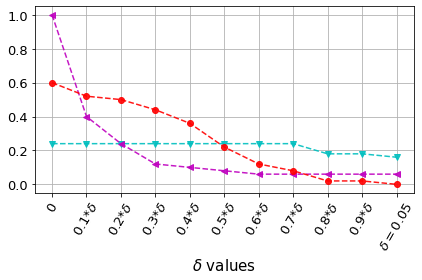

In [51]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
#ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/delta-val-credit.png", dpi=300)

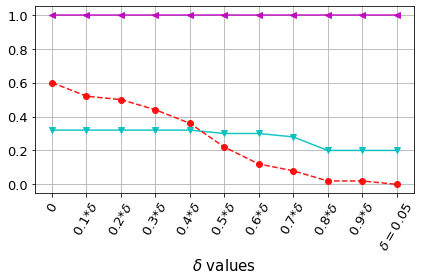

In [52]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
#ax.legend()
plt.xticks(rotation=60)
#ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/robust-delta-val-credit.png", dpi=300)